# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [34]:
geo1=pd.read_csv('D://Игорь/projects/geo_data_0.csv')
geo2=pd.read_csv('D://Игорь/projects/geo_data_1.csv')
geo3=pd.read_csv('D://Игорь/projects/geo_data_2.csv')

In [35]:
# смотрим первый датасет
geo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [36]:
geo1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [37]:
print(geo1.duplicated().sum())

0


<AxesSubplot:>

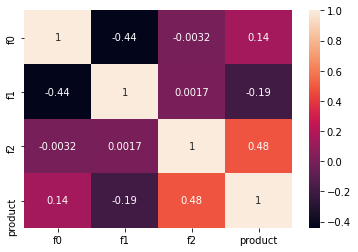

In [38]:
sns.heatmap(geo1.corr(), annot=True)

Пропусков нет, средняя кореляция есть между объемом запасов и f2

In [39]:
# смотрим второй датасет
geo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


пропуски так же отсутствуют

In [40]:
geo2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [41]:
print(geo2.duplicated().sum())

0


<AxesSubplot:>

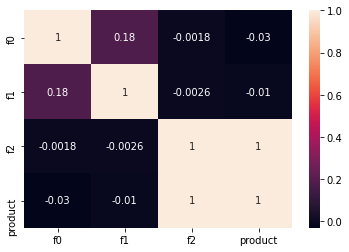

In [42]:
sns.heatmap(geo2.corr(), annot=True)

Между f2 и объемом запасов прямая зависчимость.

In [43]:
geo3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


так же отсутствуют пропуски

In [44]:
geo3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [45]:
print(geo3.duplicated().sum())

0


<AxesSubplot:>

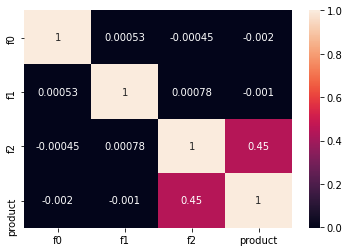

In [46]:
sns.heatmap(geo3.corr(), annot=True)

Имеется средняя корреляция между f2 и объемом запасорв

In [47]:
#Для удобства удалим столбец с id т.к. он не нужен для обученимя модели
geo1=geo1.drop(['id'], axis=1)
geo2=geo2.drop(['id'], axis=1)
geo3=geo3.drop(['id'], axis=1)

In [48]:
geo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


### Вывод:
- В датасете 5 столбцов и 100 000строк
- Пропуски и дубликаты отсутствуют
- Корреляции между f0 и f1 и объемом запасов почти отсутствует
- Во втором датасете корреляция между f2 и объемом запасов равна 1, в первом и третьем средняя корреляция
- Удален столбец id, т.к. он не нужен для обучения модели


## Обучение и проверка модели

Обучаем модель Линейной регрессии

In [49]:
# разделение выборок
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    geo1.drop(['product'], axis=1), geo1['product'], test_size=0.25, random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    geo2.drop(['product'], axis=1), geo2['product'], test_size=0.25, random_state=12345)

features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    geo3.drop(['product'], axis=1), geo3['product'], test_size=0.25, random_state=12345)

In [50]:
def model_fit(features_train, features_valid, target_train, target_valid):
        
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    predictions_mean = predictions.mean()
    rmse = mean_squared_error(target_valid, predictions)**0.5

    print('средний запас предсказанного сырья: {:.2f}'.format(predictions_mean))
    print('RMSE модели: {:.2f}'.format(rmse))
    
    return predictions

In [51]:
predictions_1 = model_fit(features_train_1, features_valid_1, target_train_1, target_valid_1)

средний запас предсказанного сырья: 92.59
RMSE модели: 37.58


In [52]:
predictions_2 = model_fit(features_train_2, features_valid_2, target_train_2, target_valid_2)

средний запас предсказанного сырья: 68.73
RMSE модели: 0.89


In [53]:
predictions_3 = model_fit(features_train_3, features_valid_3, target_train_3, target_valid_3)

средний запас предсказанного сырья: 94.97
RMSE модели: 40.03


### Вывод:
- Предсказания по первому и третьему датасету приблизительно одинаков, прогнозируется большой запас сырья, при этом так же и RMSE высок
- Предсказания по 2 датасету ниже чем в 1 и 3, но при этом RMSE меньше 1. Вероятно это переобученность модели из за корреляции с f2

## Подготовка к расчёту прибыли

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [54]:
print('Средний запас сырья по региону 1: {:.2f} тыс. бар'.format(predictions_1.mean()))
print('Средний запас сырья по региону 2: {:.2f} тыс. бар'.format(predictions_2.mean()))
print('Средний запас сырья по региону 3: {:.2f} тыс. бар'.format(predictions_3.mean()))

Средний запас сырья по региону 1: 92.59 тыс. бар
Средний запас сырья по региону 2: 68.73 тыс. бар
Средний запас сырья по региону 3: 94.97 тыс. бар


In [55]:
# сохраним данные в переменные
RESEARCH_POINTS = 500 # точки исследования
BEST_POINTS = 200 # лучшие точки
BUDGET = 10000000000 # бюджет
INCOME = 450000 # доход с каждой единицы продукции

In [56]:
budget_per_point = BUDGET / BEST_POINTS
print('Бюджет на разработку одной точки:', budget_per_point)

Бюджет на разработку одной точки: 50000000.0


In [57]:
min_barrels = budget_per_point / INCOME
print('Минимальное количество баррелей для окупаемости:', min_barrels)

Минимальное количество баррелей для окупаемости: 111.11111111111111


### Вывод:
Ни один из регионов не обеспечит необходимый запас сырья т.к. самый максимальный средний запас сырья у 3 региону составляет 94,97 тысяч баррелей, что ниже минимального количества баррелей для окупаемости.

## Расчёт прибыли и рисков 

In [58]:
# Расчет прибыли
#переведем предсказания в формат Series для сортировки
predictions_1 = pd.Series(predictions_1, index=target_valid_1.index)
predictions_2 = pd.Series(predictions_2, index=target_valid_2.index)
predictions_3 = pd.Series(predictions_3, index=target_valid_3.index)

In [59]:
#создавем функцию
def profit(target, predictions):
    predictions_sorted=predictions.sort_values(ascending=False)
    volume = target[predictions_sorted.index][:200]
    return ((volume.sum() * INCOME - BUDGET))


In [60]:
print('Предполагаемая прибыль в первом регионе из 200 лучших скважин {:.2f} рублей'
      .format(profit(target_valid_1, predictions_1)))
print('Предполагаемая прибыль во втором регионе из 200 лучших скважин {:.2f} рублей'
      .format(profit(target_valid_2, predictions_2)))
print('Предполагаемая прибыль в третьем регионе из 200 лучших скважин {:.2f} рублей'
      .format(profit(target_valid_3, predictions_3)))

Предполагаемая прибыль в первом регионе из 200 лучших скважин 3320826043.14 рублей
Предполагаемая прибыль во втором регионе из 200 лучших скважин 2415086696.68 рублей
Предполагаемая прибыль в третьем регионе из 200 лучших скважин 2710349963.60 рублей


- Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [61]:
#Расчет рисков
# Напишем функцию
def bootstrap(target_valid, predictions, geo):
    state = np.random.RandomState(12345)
    values = []
    target_valid = target_valid
    predictions = predictions
    for i in range(1000):
        target_subsample = target_valid.sample(RESEARCH_POINTS, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, predictions_subsample))
        
    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = (values < 0).mean()*100
    
    print('Регион', geo)
    print('Средняя прибыль: {:,.2f}'.format(mean))
    print('Минимальный доверительный интервал: {:,.2f}'.format(lower))
    print('Максимальный доверительный интервал: {:,.2f}'.format(upper))
    print('Риск убытков: {} %'.format(risk))

In [62]:
bootstrap (target_valid_1, predictions_1, 1)

Регион 1
Средняя прибыль: 425,938,526.91
Минимальный доверительный интервал: -102,090,094.84
Максимальный доверительный интервал: 947,976,353.36
Риск убытков: 6.0 %


In [63]:
bootstrap (target_valid_2, predictions_2, 2)

Регион 2
Средняя прибыль: 515,222,773.44
Минимальный доверительный интервал: 68,873,225.37
Максимальный доверительный интервал: 931,547,591.26
Риск убытков: 1.0 %


In [64]:
bootstrap (target_valid_3, predictions_3, 3)

Регион 3
Средняя прибыль: 435,008,362.78
Минимальный доверительный интервал: -128,880,547.33
Максимальный доверительный интервал: 969,706,954.18
Риск убытков: 6.4 %


### Вывод:
- Из расчетов менее рискованным является второй регион, минимальный доверительный интервал является положительным числом в отличии от 1 и 3 региона.

## Общий вывод:
1. Загрузка и подготовка данных:
- В датасете 5 столбцов и 100 000строк
- Пропуски и дубликаты отсутствуют
- Корреляции между f0 и f1 и объемом запасов почти отсутствует
- Во втором датасете корреляция между f2 и объемом запасов равна 1, в первом и третьем средняя корреляция
- Удален столбец id, т.к. он не нужен для обучения модели
2. Обучение и проверка модели:
- Предсказания по первому и третьему датасету приблизительно одинаков, прогнозируется большой запас сырья, при этом так же и RMSE высок
- Предсказания по 2 датасету ниже чем в 1 и 3, но при этом RMSE меньше 1. Вероятно это переобученность модели из за корреляции с f2
3. Подготовка к расчёту прибыли:
- Ни один из регионов не обеспечит необходимый запас сырья т.к. самый максимальный средний запас сырья у 3 региону составляет 94,97 тысяч баррелей, что ниже минимального количества баррелей для окупаемости.
4. Расчёт прибыли и рисков:
- Из расчетов менее рискованным является второй регион, минимальный доверительный интервал является положительным числом в отличии от 1 и 3 региона.